In [2]:
import numpy as np
import matplotlib.pyplot as plt
from layers import *

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [4]:
N = 1
H = 1
T = 20

dh = np.ones((N, H))
np.random.seed(3)


[[1.78862847]]


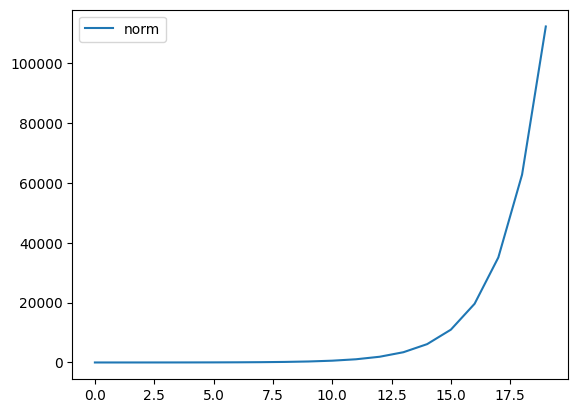

In [5]:
Wh = np.random.randn(H, H)
print(Wh)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm_list.append(dh)

norm_list
# norm_list 시각화
norm = np.array(norm_list)
norm = np.squeeze(norm)
plt.plot(norm, label='norm')
plt.legend()
plt.show()

[[0.21825493]]


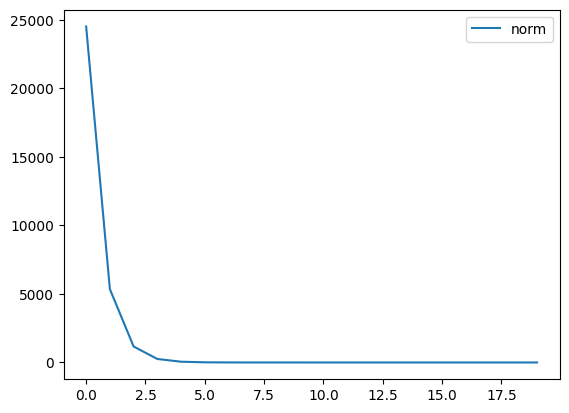

In [6]:
Wh = np.random.randn(H, H) * 0.5 # 가중치를 0.5배로 줄임
print(Wh)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm_list.append(dh)

norm = np.array(norm_list)
norm = np.squeeze(norm)
plt.plot(norm, label='norm')
plt.legend()
plt.show()

### LSTM 계층  

In [7]:
class LSTM:
  def __init__(self,Wx,Wh,b):
    self.params = [Wx,Wh,b] # 가중치에는 4개분의 가중치가 담겨 있다. input gate, forget gate, output gate, block input의 가중치 4개
    self.grads = [np.zeros_like(Wx),np.zeros_like(Wh),np.zeros_like(b)] # 기울기를 저장하는 grads 인스턴스 변수 초기화
    self.cache = None       # 순전파시 중간 결과를 담을 cache변수로 역전파 계산에 사용하는 인스턴스 변수 cache를 초기화
  
  # 순전파
  def forward(self, x, h_prev, c_prev): # x는 입력 데이터, h_prev는 이전 시각의 은닉 상태, c_prev는 이전 시각의 기억 셀
    Wx, Wh, b = self.params
    N, H = h_prev.shape

    A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b  # 4개의 가중치를 모아 아핀 변환을 수행하여 A를 계산

    f = A[:, :H]
    g = A[:, H:2*H]
    i = A[:, 2*H:3*H]
    o = A[:, 3*H:]

    f = sigmoid(f)                # forget gate
    g = np.tanh(g)                # 새로운 정보를 기억하기 위한 input
    i = sigmoid(i)                # input gate
    o = sigmoid(o)                # output gate

    c_next = f * c_prev + g * i   # 기억 셀(memory cell) 계산, c_next = f * c_prev + g * i
    h_next = o * np.tanh(c_next)  # 은닉 상태 계산, h_next = o * tanh(c_next)

    self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
    return h_next, c_next         # 은닉 상태(hidden state)와 기억 셀(memory cell)을 반환
  
  # 역전파
  def backward(self, dh_next, dc_next):
    Wx, Wh, b = self.params
    x, h_prev, c_prev, i, f, g, o, c_next = self.cache

    tanh_c_next = np.tanh(c_next)

    ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)  # ds는 c_next로부터 전달되는 기울기와 h_next로부터 전달되는 기울기를 더한 값

    dc_prev = ds * f  # 기억 셀의 기울기 dc_prev 계산, ds와 f를 곱함

    di = ds * g
    df = ds * c_prev
    do = dh_next * tanh_c_next
    dg = ds * i

    di *= i * (1 - i)
    df *= f * (1 - f)
    do *= o * (1 - o)
    dg *= (1 - g ** 2)

    dA = np.hstack((df, dg, di, do))

    dWh = np.dot(h_prev.T, dA)
    dWx = np.dot(x.T, dA)
    db = dA.sum(axis=0)
    
    # dWx, dWh, db를 각각 grads의 0, 1, 2번째 인덱스에 저장, 4개(input gate, forget gate, output gate, block input)의 가중치에 대한 기울기를 저장
    self.grads[0][...] = dWx        
    self.grads[1][...] = dWh
    self.grads[2][...] = db

    dx = np.dot(dA, Wx.T)
    dh_prev = np.dot(dA, Wh.T)

    return dx, dh_prev, dc_prev

### Time LSTM 계층    

In [8]:
# T개 분의 시계열 데이터를 한꺼번에 처리하는 TimeLSTM 계층
class TimeLSTM:
  def __init__(self, Wx, Wh, b , stateful=False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.layers = None

    self.h, self.c = None, None   # hidden state, cell state
    self.dh = None
    self.stateful = stateful
  
  def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape
    H = Wh.shape[0]

    self.layers = []
    hs = np.empty((N, T, H), dtype='f')     # 출력값을 저장할 변수 hs를 초기화

    if not self.stateful or self.h is None:
      self.h = np.zeros((N, H), dtype='f')
    if not self.stateful or self.c is None:
      self.c = np.zeros((N, H), dtype='f')
    
    for t in range(T):
      layer = LSTM(*self.params)
      self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
      hs[:, t, :] = self.h

      self.layers.append(layer)
    
    return hs
  
  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D = Wx.shape[0]

    dxs = np.empty((N, T, D), dtype='f')
    dh, dc = 0, 0

    grads = [0, 0, 0]
    for t in reversed(range(T)):
      layer = self.layers[t]
      dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
      dxs[:, t, :] = dx
      for i, grad in enumerate(layer.grads):
        grads[i] += grad
    
    for i, grad in enumerate(grads):
      self.grads[i][...] = grad
    self.dh = dh
    return dxs
  
  def set_state(self, h, c=None):
    self.h, self.c = h, c
  
  # 상태 초기화
  def reset_state(self):
    self.h, self.c = None, None

In [9]:
import pickle
from time_layers import TimeEmbedding, TimeAffine, TimeSoftmaxWithLoss

In [10]:
class Rnnlm:
  def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
      V, D, H = vocab_size, wordvec_size, hidden_size
      rn = np.random.randn

      # 가중치 초기화
      embed_W = (rn(V, D) / 100).astype('f')
      lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
      lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
      lstm_b = np.zeros(4 * H).astype('f')
      affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
      affine_b = np.zeros(V).astype('f')

      # 계층 생성
      self.layers = [
          TimeEmbedding(embed_W),
          TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
          TimeAffine(affine_W, affine_b)
      ]
      self.loss_layer = TimeSoftmaxWithLoss()
      self.lstm_layer = self.layers[1] # TimeLSTM 계층을 가리킴

      # 모든 가중치와 기울기를 리스트에 모은다.
      self.params, self.grads = [], []
      for layer in self.layers:
          self.params += layer.params
          self.grads += layer.grads

  # 예측, softmax 계층 직전까지를 처리 
  def predict(self, xs):        
      for layer in self.layers:
          xs = layer.forward(xs)
      return xs

  def forward(self, xs, ts):
      score = self.predict(xs)
      loss = self.loss_layer.forward(score, ts)
      return loss

  def backward(self, dout=1):
      dout = self.loss_layer.backward(dout)
      for layer in reversed(self.layers):
          dout = layer.backward(dout)
      return dout

  def reset_state(self):
      self.lstm_layer.reset_state()
      
  def save_params(self, file_name='Rnnlm.pkl'):
      with open(file_name, 'wb') as f:
          pickle.dump(self.params, f)
          
  def load_params(self, file_name='Rnnlm.pkl'):
      with open(file_name, 'rb') as f:
          self.params = pickle.load(f)

In [11]:
from ptb import load_data
from optimizer import SGD
from trainer import RnnlmTrainer
from util import eval_perplexity

In [12]:
# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = load_data('train')
corpus_test, _, _ = load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성 
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)                       # 옵티마이저 생성, 학습률 20.0, SGD로 설정
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()                              # 이전 시간 단계의 은닉 상태, 셀 상태를 초기화하여 테스트 데이터에 대한 평가를 수행  
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 학습된 매개변수 저장
model.save_params()                          # 학습된 매개변수를 저장하여 나중에 사용할 수 있도록 함

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9999.48
| 에폭 1 |  반복 21 / 1327 | 시간 4[s] | 퍼플렉서티 2898.21


KeyboardInterrupt: 

In [13]:
import numpy as np

# Parameters
D = 4  # Input dimension
H = 4  # Hidden state dimension

# Randomly initialize weights and biases for forget gate
W_xf = np.random.randn(D, H)  # Input-to-forget gate weights
W_hf = np.random.randn(H, H)  # Hidden-to-forget gate weights
b_f = np.random.randn(H)      # Forget gate bias

# Input data (4-dimensional vector)
x_t = np.random.rand(D)

# Previous hidden state (4-dimensional vector)
h_t_prev = np.random.rand(H)

# Forget gate calculation
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Forget gate output
f_t = sigmoid(np.dot(x_t, W_xf) + np.dot(h_t_prev, W_hf) + b_f)

print("Input data (x_t):", x_t)
print("Previous hidden state (h_t_prev):", h_t_prev)
print("Forget gate output (f_t):", f_t)

Input data (x_t): [0.35068735 0.8086325  0.02123691 0.90268922]
Previous hidden state (h_t_prev): [0.49109703 0.54483852 0.74416622 0.38907102]
Forget gate output (f_t): [0.14685852 0.36053943 0.1092042  0.36639851]


In [14]:
# Parameters
D = 4  # Input dimension
H = 3  # Hidden state dimension

# Randomly initialize weights and biases for LSTM gates
W_xf = np.random.randn(D, H)  # Input-to-forget gate weights
W_hf = np.random.randn(H, H)  # Hidden-to-forget gate weights
b_f = np.random.randn(H)      # Forget gate bias

W_xi = np.random.randn(D, H)  # Input-to-input gate weights
W_hi = np.random.randn(H, H)  # Hidden-to-input gate weights
b_i = np.random.randn(H)      # Input gate bias

W_xc = np.random.randn(D, H)  # Input-to-cell gate weights
W_hc = np.random.randn(H, H)  # Hidden-to-cell gate weights
b_c = np.random.randn(H)      # Cell gate bias

W_xo = np.random.randn(D, H)  # Input-to-output gate weights
W_ho = np.random.randn(H, H)  # Hidden-to-output gate weights
b_o = np.random.randn(H)      # Output gate bias

# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Input data (4-dimensional vector)
x_t = np.random.rand(D)
print("Input data (x_t):", x_t)

# Previous hidden state and cell state
h_t_prev = np.random.rand(H)
c_t_prev = np.random.rand(H)

# LSTM Forward Propagation
# Forget gate
f_t = sigmoid(np.dot(x_t, W_xf) + np.dot(h_t_prev, W_hf) + b_f)

# Input gate
i_t = sigmoid(np.dot(x_t, W_xi) + np.dot(h_t_prev, W_hi) + b_i)

# Candidate cell state
c_tilde_t = np.tanh(np.dot(x_t, W_xc) + np.dot(h_t_prev, W_hc) + b_c)

# Update cell state
c_t = f_t * c_t_prev + i_t * c_tilde_t   

# Output gate
o_t = sigmoid(np.dot(x_t, W_xo) + np.dot(h_t_prev, W_ho) + b_o)

# Update hidden state
h_t = o_t * np.tanh(c_t)

# Print results
print("Forget gate (f_t):", f_t)
print("Input gate (i_t):", i_t)
print("Candidate cell state (c_tilde_t):", c_tilde_t)
print("Updated cell state (c_t):", c_t)
print("Output gate (o_t):", o_t)
print("Updated hidden state (h_t):", h_t)

# Backpropagation for Cell State
# Assume some loss gradient with respect to the cell state
dL_dc_t = np.random.rand(H)  # Gradient of the loss with respect to c_t, 지금 시각(t)의 기억 셀 상태에 대한 손실의 기울기

# Gradients of the cell state components
dc_t_prev = dL_dc_t * f_t

df_t = dL_dc_t * c_t_prev

di_t = dL_dc_t * c_tilde_t

dc_tilde_t = dL_dc_t * i_t

# Gradients through activation functions
df_t_raw = df_t * f_t * (1 - f_t)  # Sigmoid derivative
di_t_raw = di_t * i_t * (1 - i_t)  # Sigmoid derivative
dc_tilde_t_raw = dc_tilde_t * (1 - c_tilde_t ** 2)  # Tanh derivative

# Print backpropagation results
print("Backpropagation gradients:")
print("dL/dc_t_prev:", dc_t_prev) # 이전 시각의 기억 셀 상태에 대한 기울기
print("dL/df_t_raw:", df_t_raw)
print("dL/di_t_raw:", di_t_raw)
print("dL/dc_tilde_t_raw:", dc_tilde_t_raw)


Input data (x_t): [0.98289007 0.33770539 0.1535576  0.90088095]
Forget gate (f_t): [0.86828884 0.56384413 0.11611163]
Input gate (i_t): [0.28885163 0.94775288 0.07904585]
Candidate cell state (c_tilde_t): [-0.9470082   0.99829399  0.99958123]
Updated cell state (c_t): [0.54813878 1.17660199 0.12513033]
Output gate (o_t): [0.26903942 0.23846758 0.78640542]
Updated hidden state (h_t): [0.13428402 0.19706415 0.09789278]
Backpropagation gradients:
dL/dc_t_prev: [0.35129444 0.5320952  0.06875347]
dL/df_t_raw: [0.0437859  0.09485907 0.02413697]
dL/di_t_raw: [-0.07870383  0.04664942  0.04308778]
dL/dc_tilde_t_raw: [1.20575285e-02 3.04905926e-03 3.91931093e-05]
